# Step 4 model: random forrest & DT

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [38]:
path = "C:/Users/kleis500/Eclipse workspace/kaggle/japan restaurant/data/"
reservation_data=pd.read_csv(path+'reservation_data.csv',sep=";")
reservation_data['visit_datetime'] = pd.to_datetime(reservation_data['visit_date'])
print(reservation_data.info())
reservation_data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42193 entries, 0 to 42192
Data columns (total 12 columns):
Unnamed: 0                         42193 non-null int64
air_store_id                       42193 non-null object
visit_date                         42193 non-null object
sum_visitors                       42193 non-null int64
avg_diff_reservation_visit_days    42193 non-null int64
visit_datetime                     42193 non-null datetime64[ns]
weekday                            42193 non-null int64
weekday_name                       42193 non-null object
year                               42193 non-null int64
month                              42193 non-null int64
day_of_week                        42193 non-null object
holiday_flg                        42193 non-null int64
dtypes: datetime64[ns](1), int64(7), object(4)
memory usage: 3.9+ MB
None


,Unnamed: 0,air_store_id,visit_date,sum_visitors,avg_diff_reservation_visit_days,visit_datetime,weekday,weekday_name,year,month,day_of_week,holiday_flg
42188,42188,air_fea5dc9594450608,2017-04-22,4,0,2017-04-22,5,Saturday,2017,4,Saturday,0
42189,42189,air_fea5dc9594450608,2017-04-25,4,18,2017-04-25,1,Tuesday,2017,4,Tuesday,0
42190,42190,air_fea5dc9594450608,2017-04-28,6,58,2017-04-28,4,Friday,2017,4,Friday,0
42191,42191,air_fea5dc9594450608,2017-05-20,12,68,2017-05-20,5,Saturday,2017,5,Saturday,0
42192,42192,air_fee8dcf4d619598e,2017-01-09,5,16,2017-01-09,0,Monday,2017,1,Monday,1


In [43]:
#print(len(reservation_data.air_store_id.unique()))
#len(visit_data.air_store_id.unique())

In [5]:
visit_data=pd.read_csv(path+'air_visit_data.csv')
visit_data['visit_datetime']=pd.to_datetime(visit_data['visit_date'])
visit_data['weekday'] = visit_data['visit_datetime'].dt.weekday
visit_data['weekday_'] = visit_data['visit_datetime'].dt.weekday_name
visit_data['year'] = visit_data['visit_datetime'].dt.year
visit_data['month'] = visit_data['visit_datetime'].dt.month
print(visit_data.info())
visit_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 8 columns):
air_store_id      252108 non-null object
visit_date        252108 non-null object
visitors          252108 non-null int64
visit_datetime    252108 non-null datetime64[ns]
weekday           252108 non-null int64
weekday_          252108 non-null object
year              252108 non-null int64
month             252108 non-null int64
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 15.4+ MB
None


,air_store_id,visit_date,visitors,visit_datetime,weekday,weekday_,year,month
0,air_ba937bf13d40fb24,2016-01-13,25,2016-01-13,2,Wednesday,2016,1
1,air_ba937bf13d40fb24,2016-01-14,32,2016-01-14,3,Thursday,2016,1
2,air_ba937bf13d40fb24,2016-01-15,29,2016-01-15,4,Friday,2016,1
3,air_ba937bf13d40fb24,2016-01-16,22,2016-01-16,5,Saturday,2016,1
4,air_ba937bf13d40fb24,2016-01-18,6,2016-01-18,0,Monday,2016,1


In [56]:
reserve_visit_data=pd.merge(visit_data, reservation_data, how='inner', on=['air_store_id', 'weekday', 'year', 'month','visit_date', 'visit_datetime'])
reserve_visit_data.drop('Unnamed: 0', inplace=True, axis=1)
reserve_visit_data.head(2)

,air_store_id,visit_date,visitors,visit_datetime,weekday,weekday_,year,month,sum_visitors,avg_diff_reservation_visit_days,weekday_name,day_of_week,holiday_flg
0,air_35512c42db0868da,2016-02-27,6,2016-02-27,5,Saturday,2016,2,12,0,Saturday,Saturday,0
1,air_ee3a01f0c71a769f,2016-01-04,61,2016-01-04,0,Monday,2016,1,2,0,Monday,Monday,0


In [58]:
reserve_visit_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35698 entries, 0 to 35697
Data columns (total 13 columns):
air_store_id                       35698 non-null object
visit_date                         35698 non-null object
visitors                           35698 non-null int64
visit_datetime                     35698 non-null datetime64[ns]
weekday                            35698 non-null int64
weekday_                           35698 non-null object
year                               35698 non-null int64
month                              35698 non-null int64
sum_visitors                       35698 non-null int64
avg_diff_reservation_visit_days    35698 non-null int64
weekday_name                       35698 non-null object
day_of_week                        35698 non-null object
holiday_flg                        35698 non-null int64
dtypes: datetime64[ns](1), int64(7), object(5)
memory usage: 3.8+ MB


In [59]:
X = reserve_visit_data.drop(['visitors', 'visit_datetime', 'weekday_', 'weekday_name','visit_date', 'air_store_id', 'day_of_week'], axis=1)
y = reserve_visit_data['visitors']  

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, test_size=0.4, shuffle = True, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [60]:
predicted_values = clf.predict(X_test)

In [61]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
topX=25
names = [X.columns[i] for i in indices[:topX]]
print(names)

['avg_diff_reservation_visit_days', 'sum_visitors', 'month', 'weekday', 'year', 'holiday_flg']


In [62]:
import numpy as np
from sklearn import metrics 
results={'datasize':str(X.shape),
         'mae': metrics.mean_absolute_error(y_test, predicted_values),
         'rmse': np.sqrt(metrics.mean_squared_error(y_test, predicted_values))}        
results

{'datasize': '(35698, 6)',
 'mae': 14.893767507002801,
 'rmse': 20.679867813240712}

K-means

Label encoding 
Label encoding generates unique integers linked to string data
Therefore the air_store_id can be used as a feature for the model, as it afterwards is from type integer. 
 

In [72]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(reserve_visit_data['air_store_id'])

LabelEncoder()

In [73]:
reserve_visit_data['store_int'] = le.transform(reserve_visit_data['air_store_id']) 

In [75]:
reserve_visit_data.head() 

,air_store_id,visit_date,visitors,visit_datetime,weekday,weekday_,year,month,sum_visitors,avg_diff_reservation_visit_days,weekday_name,day_of_week,holiday_flg,store_int
0,air_35512c42db0868da,2016-02-27,6,2016-02-27,5,Saturday,2016,2,12,0,Saturday,Saturday,0,66
1,air_ee3a01f0c71a769f,2016-01-04,61,2016-01-04,0,Monday,2016,1,2,0,Monday,Monday,0,310
2,air_ee3a01f0c71a769f,2016-01-08,21,2016-01-08,4,Friday,2016,1,3,2,Friday,Friday,0,310
3,air_ee3a01f0c71a769f,2016-01-09,57,2016-01-09,5,Saturday,2016,1,25,35,Saturday,Saturday,0,310
4,air_ee3a01f0c71a769f,2016-01-10,32,2016-01-10,6,Sunday,2016,1,5,4,Sunday,Sunday,0,310


Return original air_store_id based on linken store_int 

In [78]:
#list(le.inverse_transform(reserve_visit_data['store_int'])) 

In [79]:
airstore_info=pd.read_csv(path+'air_store_info.csv')

In [97]:
Xi =airstore_info[['latitude','longitude']] 
Xi.head()

,latitude,longitude
0,34.695124,135.197852
1,34.695124,135.197852
2,34.695124,135.197852
3,34.695124,135.197852
4,35.658068,139.751599


In [98]:
k_means=KMeans(n_clusters=2,random_state=0).fit(Xi)
cluster_values=k_means.predict(X)

In [99]:
Xi['labels'] = k_means.labels_
# df_labels=pd.DataFrame({'labels': kmeans.labels_})
label_groups = Xi.groupby('labels')

for name, group in label_groups:
    print(name) 
    print(group.describe())

0
         latitude   longitude  labels
count  290.000000  290.000000   290.0
mean    34.185851  132.885989     0.0
std      0.543072    2.331176     0.0
min     33.211967  130.195555     0.0
25%     33.589216  130.392813     0.0
50%     34.386245  132.455018     0.0
75%     34.695124  135.472229     0.0
max     34.815149  135.628100     0.0
1
         latitude   longitude  labels
count  539.000000  539.000000   539.0
mean    36.433212  139.852237     1.0
std      2.181700    0.766609     0.0
min     34.710895  137.725940     1.0
25%     35.658068  139.697689     1.0
50%     35.672853  139.715963     1.0
75%     35.712607  139.771861     1.0
max     44.020632  144.273398     1.0


C:\Users\kleis500\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [100]:
distortions=[]
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(Xi)
    kmeanModel.fit(Xi)
    distortions.append(sum(np.min(cdist(Xi, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / Xi.shape[0])

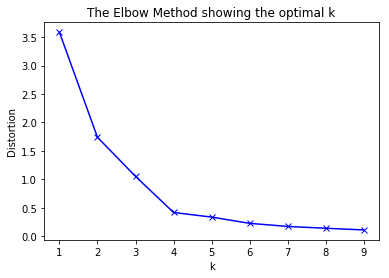

In [101]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [102]:
reserve_visit_info_data=pd.merge(reserve_visit_data, airstore_info, how='inner', on=['air_store_id'])
reserve_visit_info_data.info()
reserve_visit_info_data.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35698 entries, 0 to 35697
Data columns (total 18 columns):
air_store_id                       35698 non-null object
visit_date                         35698 non-null object
visitors                           35698 non-null int64
visit_datetime                     35698 non-null datetime64[ns]
weekday                            35698 non-null int64
weekday_                           35698 non-null object
year                               35698 non-null int64
month                              35698 non-null int64
sum_visitors                       35698 non-null int64
avg_diff_reservation_visit_days    35698 non-null int64
weekday_name                       35698 non-null object
day_of_week                        35698 non-null object
holiday_flg                        35698 non-null int64
store_int                          35698 non-null int64
air_genre_name                     35698 non-null object
air_area_name                      3

,air_store_id,visit_date,visitors,visit_datetime,weekday,weekday_,year,month,sum_visitors,avg_diff_reservation_visit_days,weekday_name,day_of_week,holiday_flg,store_int,air_genre_name,air_area_name,latitude,longitude
0,air_35512c42db0868da,2016-02-27,6,2016-02-27,5,Saturday,2016,2,12,0,Saturday,Saturday,0,66,Dining bar,Tōkyō-to Musashino-shi Midorichō,35.717784,139.56626


In [106]:
len(reserve_visit_info_data.air_area_name.unique())

72